In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

from demo_components import MaximalCodingRateReduction, Z_loss, chunk_avg, Gumble_Softmax, get_data, MLP_net

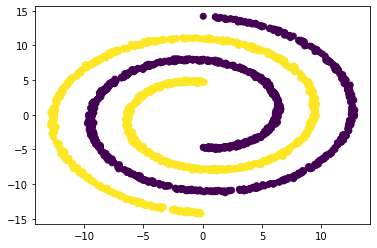

In [2]:
#Display original data
x, cluster_id = get_data(2000)
plt.scatter(x[:,0],x[:,1],c=cluster_id)

In [ ]:
#Train
n_steps = 30000
print_every = 50
bs = 4096

#task variables
amb_dim = 2
z_dim = 6
noise = 0.
n_clusters = 2
aug_noise = 0.2

net = MLP_net(amb_dim,128,z_dim,n_clusters)

optimizer = optim.Adam(net.parameters(),lr=0.001,betas=(0.9,0.99),weight_decay=0.00001)
G_Softmax = Gumble_Softmax(0.2,straight_through=False)

criterion = MaximalCodingRateReduction(eps=0.01,gamma=1.0)
criterion_z = Z_loss()

for i in range(n_steps):
    x, _ = get_data(bs,contrastive=True,aug_noise=aug_noise)
    x = torch.cat(x,dim=0).float()

    z, logits = net(x)
    loss_z, z_sim = criterion_z(z)
    z_sim = z_sim.mean()
    
    prob = G_Softmax(logits)
    z, prob = chunk_avg(z,n_chunks=2,normalize=True), chunk_avg(prob,n_chunks=2)
    
    loss, loss_list= criterion(z,prob,num_classes=n_clusters)
    
    loss += 4000*loss_z
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%print_every == 0:
        print('{} steps done, loss c {}, loss d {}, z sim {}'.format(i+1,loss_list[0],loss_list[1],z_sim.item()))

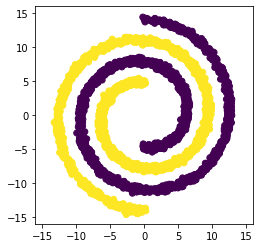

In [6]:
#visualize clustering
n_samples = 4096
x, cluster_ids = get_data(n_samples,contrastive=True,aug_noise=aug_noise)
x = x[0].float()
with torch.no_grad():
    z, logits = net(x)
    preds = logits.max(dim=1)[1]
x = x.detach()

#plotting
fig, ax = plt.subplots()
ax.scatter(x[:,0],x[:,1],c=preds)
ax.set_xlim(xmin=-16,xmax=16)
ax.set_ylim(ymin=-16,ymax=16)
ax.set_aspect('equal')
plt.show()